In [ ]:
import kagglehub
import os
path = kagglehub.dataset_download("xhlulu/140k-real-and-fake-faces")

print("Path to dataset files:", path)

100%|██████████| 3.75G/3.75G [03:05<00:00, 21.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/xhlulu/140k-real-and-fake-faces/versions/2


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image



In [ ]:
from PIL import Image

class RealFakeDataset(Sequence):
    def __init__(self, csv_file, root_dir, batch_size=32, image_size=(256, 256), shuffle=True, limit=100000):
        self.data = pd.read_csv(csv_file).sample(n=limit, random_state=42)
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size: (index + 1) * self.batch_size]
        batch_data = self.data.iloc[batch_indices]
        images, labels = [], []
        for img_path, label in zip(batch_data['path'], batch_data['label']):
            original_image = self.__load_image(img_path)
            rotated_images = self.__generate_rotations(original_image)
            images.extend(rotated_images)
            labels.extend([label] * len(rotated_images))
        return np.array(images), np.array(labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __load_image(self, img_path):
        img_path_full = os.path.join(self.root_dir, img_path)
        img = Image.open(img_path_full).resize(self.image_size)
        img = np.array(img) / 255.0
        return img

    def __generate_rotations(self, image):
        pil_image = Image.fromarray((image * 255).astype(np.uint8))
        rotated_45 = pil_image.rotate(45, resample=Image.BICUBIC)
        rotated_90 = pil_image.rotate(90, resample=Image.BICUBIC)
        rotated_180 = pil_image.rotate(180, resample=Image.BICUBIC)
        return [
            np.array(pil_image) / 255.0,
            np.array(rotated_45) / 255.0,
            np.array(rotated_90) / 255.0,
            np.array(rotated_180) / 255.0
        ]


In [ ]:
root_dir = "%s/real_vs_fake/real-vs-fake" % path
train_csv = "%s/train.csv" % path
valid_csv = "%s/valid.csv" % path
test_csv = "%s/test.csv" % path

train_dataset = RealFakeDataset(csv_file=train_csv, root_dir=root_dir, limit=20000)
valid_dataset = RealFakeDataset(csv_file=valid_csv, root_dir=root_dir, limit=20000)
test_dataset = RealFakeDataset(csv_file=test_csv, root_dir=root_dir, limit=20000)


In [ ]:
def build_model(input_shape=(256, 256, 3)):
    input = tf.keras.Input(shape=input_shape)

    densenet = tf.keras.applications.DenseNet121( weights="imagenet", include_top=False, input_tensor = input)

    x = tf.keras.layers.GlobalAveragePooling2D()(densenet.output)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x) #binary classification

    model = tf.keras.Model(densenet.input, output)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model


In [ ]:
model = build_model()

history = model.fit(train_dataset, validation_data=valid_dataset, epochs=3)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 1553s 2s/step - accuracy: 0.7091 - loss: 0.6092 - val_accuracy: 0.7789 - val_loss: 0.4763
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 1346s 2s/step - accuracy: 0.9303 - loss: 0.1771 - val_accuracy: 0.6849 - val_loss: 1.1228
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 1359s 2s/step - accuracy: 0.9246 - loss: 0.1914 - val_accuracy: 0.8277 - val_loss: 0.4700


In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc * 100:.2f}%")


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 453s 724ms/step - accuracy: 0.8294 - loss: 0.4622
Test accuracy: 82.90%


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: Mountpoint must not already contain files

In [ ]:
model.save("/content/drive/MyDrive/bakalarska_praca/models/20000img+rot_DenseNet121_3e_05drop.keras")


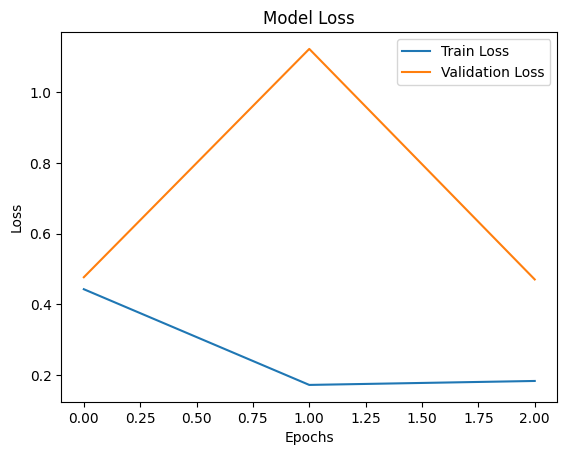

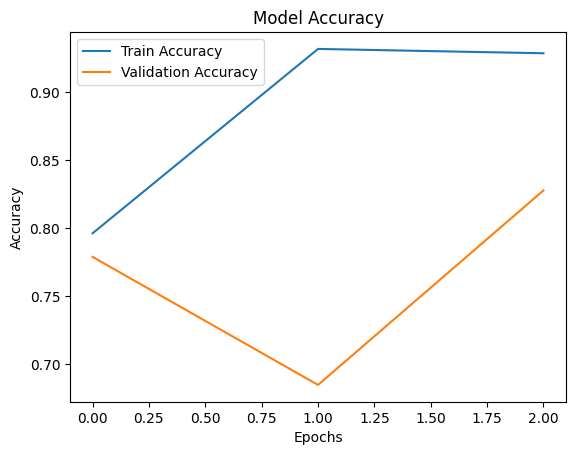

In [ ]:

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model


In [ ]:
model = load_model("/content/drive/MyDrive/bakalarska_praca/models/20000img+rot_DenseNet121_3e_05drop.keras")